In [0]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tqdm.notebook import tqdm

In [28]:
directory = '/content/drive/My Drive/NWPU-RESISC45/lake'
images = []
for file in tqdm(sorted(os.listdir(directory))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(directory + '/' + file)
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    images.append(image)

images = np.array(images)

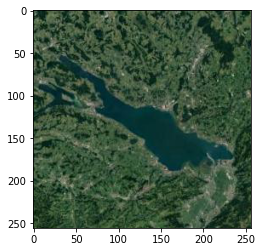

In [30]:
plt.imshow(images[np.random.randint(0,len(images))])
plt.show()